In [ ]:
!pip install kagglehub tensorflow

import kagglehub, os, shutil, pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

In [ ]:
dataset_path = kagglehub.dataset_download("jenny18/honey-bee-annotated-images")
print("Dataset downloaded to:", dataset_path)

csv_path = os.path.join(dataset_path, "bee_data.csv")
img_dir = os.path.join(dataset_path, "bee_imgs")

Using Colab cache for faster access to the 'honey-bee-annotated-images' dataset.
Dataset downloaded to: /kaggle/input/honey-bee-annotated-images


In [ ]:
base_dir = "/content/bee_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [ ]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir + "/healthy")
os.makedirs(train_dir + "/unhealthy")
os.makedirs(val_dir + "/healthy")
os.makedirs(val_dir + "/unhealthy")

In [ ]:
df = pd.read_csv(csv_path)
df["label"] = df["health"].apply(lambda x: "healthy" if str(x).lower()=="healthy" else "unhealthy")

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
def copy_images(dataframe, target_dir):
    for _, row in dataframe.iterrows():
        src = os.path.join(img_dir, row["file"])
        if os.path.exists(src):
            dest = os.path.join(target_dir, row["label"], row["file"])
            shutil.copy(src, dest)

In [ ]:
copy_images(train_df, train_dir)
copy_images(val_df, val_dir)

print("Train images:", sum(len(files) for _,_,files in os.walk(train_dir)))
print("Val images:", sum(len(files) for _,_,files in os.walk(val_dir)))

Train images: 0
Val images: 0


In [ ]:
import os, pandas as pd

dataset_path = "/kaggle/input/honey-bee-annotated-images"
csv_path = os.path.join(dataset_path, "bee_data.csv")
df = pd.read_csv(csv_path)

img_dir = os.path.join(dataset_path, "bee_imgs", "bee_imgs")

# Check if files exist
missing = 0
for f in df['file'].head(20):
    full = os.path.join(img_dir, f)
    if not os.path.exists(full):
        missing += 1
        print("Missing:", full)
print("Total missing in first 20:", missing)
print("Example existing files:")
for i in range(5):
    print(os.path.join(img_dir, df['file'].iloc[i]), os.path.exists(os.path.join(img_dir, df['file'].iloc[i])))

Total missing in first 20: 0
Example existing files:
/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/041_066.png True
/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/041_072.png True
/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/041_073.png True
/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/041_067.png True
/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/041_059.png True


In [ ]:
#main code import of dataset
from sklearn.model_selection import train_test_split

base_dir = "/content/bee_dataset"
dataset_path = "/kaggle/input/honey-bee-annotated-images"
img_dir = os.path.join(dataset_path, "bee_imgs", "bee_imgs")
csv_path = os.path.join(dataset_path, "bee_data.csv")

df = pd.read_csv(csv_path)
df['label'] = df['health'].apply(lambda x: 'healthy' if x.strip().lower() == 'healthy' else 'unhealthy')

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

for split_name, split_df in [('train', train_df), ('val', val_df)]:
    for label in ['healthy', 'unhealthy']:
        os.makedirs(os.path.join(base_dir, split_name, label), exist_ok=True)
    for _, row in split_df.iterrows():
        src = os.path.join(img_dir, row['file'])
        dst = os.path.join(base_dir, split_name, row['label'], row['file'])
        if os.path.exists(src):
            shutil.copy(src, dst)

train_count = sum([len(files) for _, _, files in os.walk(os.path.join(base_dir, 'train'))])
val_count = sum([len(files) for _, _, files in os.walk(os.path.join(base_dir, 'val'))])
print("Train images:", train_count)
print("Val images:", val_count)

Train images: 4137
Val images: 1035


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir, target_size=(128,128), batch_size=32, class_mode='binary'
)
val_gen = datagen.flow_from_directory(
    val_dir, target_size=(128,128), batch_size=32, class_mode='binary'
)

Found 4137 images belonging to 2 classes.
Found 1035 images belonging to 2 classes.


In [ ]:
#CNN

model = models.Sequential([
    layers.Input(shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.6884 - loss: 0.6008 - val_accuracy: 0.8976 - val_loss: 0.3465
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.8471 - loss: 0.3706 - val_accuracy: 0.8763 - val_loss: 0.3257
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.8852 - loss: 0.2926 - val_accuracy: 0.8937 - val_loss: 0.2804
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.8991 - loss: 0.2509 - val_accuracy: 0.8986 - val_loss: 0.2526
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.8987 - loss: 0.2424 - val_accuracy: 0.9092 - val_loss: 0.2222
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9075 - loss: 0.2194 - val_accuracy: 0.9237 - val_loss: 0.1758
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.9157 - loss: 0.2036 - val_accuracy: 0.9420 - val_loss: 0.1784
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9218 - loss: 0

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9805 - loss: 0.0522
Validation Accuracy: 0.9787


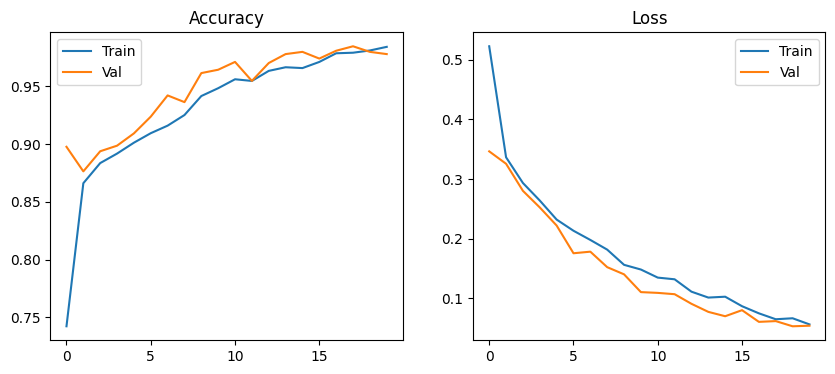

In [ ]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
model.save("bee_health_cnn_best.h5")

In [ ]:
model.save("bee_health_cnn.keras")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/test1_healthy.png"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: healthy


In [ ]:
img_path = "/content/test3_unhealthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: healthy


In [ ]:
img_path = "/content/test4_healthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: unhealthy


In [ ]:
img_path = "/content/test5_unhealthy.png"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted: unhealthy


In [ ]:
img_path = "/content/test6_healthy.png"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: healthy


In [ ]:
img_path = "/content/test7_antprob.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: unhealthy


In [ ]:
img_path = "/content/test8_unhealthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: unhealthy


In [ ]:
img_path = "/content/test9_unhealthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted: unhealthy


In [ ]:
img_path = "/content/test10_healthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted: healthy


In [ ]:
img_path = "/content/test2_healthy.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0
prediction = model.predict(x)
label = "healthy" if prediction[0][0] < 0.5 else "unhealthy"
print("Predicted:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted: healthy


In [ ]:
from google.colab import files
model.save("/content/bee_cnn_model.keras")
files.download("/content/bee_cnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>